In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, chisquare
from scipy.stats.contingency import expected_freq
from scipy.stats import kstest
from scipy.stats import nbinom
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import itertools
from google.colab import drive
drive.mount('/content/drive')
TOM_FILES_DIR = "/content/drive/My Drive/Colab Notebooks/data science- transportation research/"
MAX_FILES_DIR = "/content/drive/My Drive/data science- transportation research/"
FILES_DIR = TOM_FILES_DIR

Mounted at /content/drive


In [ ]:
FIRST_YEAR = 2013
SECOND_YEAR = 2022

In [ ]:
def filter_rows(chunk):
    return chunk[(chunk['YEAR'] == FIRST_YEAR) | (chunk['YEAR'] == SECOND_YEAR)]
chunk_size = 2000
filtered_chunks = []

for i, chunk in enumerate(pd.read_csv(f"{FILES_DIR}data_to_models.csv", chunksize=chunk_size)):
    filtered_chunk = filter_rows(chunk)
    filtered_chunks.append(filtered_chunk)
    if i%1000==0:
      print(f"iteration number {i}")

df = pd.concat(filtered_chunks)

iteration number 0
iteration number 1000
iteration number 2000
iteration number 3000
iteration number 4000
iteration number 5000
iteration number 6000
iteration number 7000
iteration number 8000


In [ ]:
df_first_jan = df[(df["YEAR"]==FIRST_YEAR)&(df["MONTH"]==1)]
df_second_jan = df[(df["YEAR"]==SECOND_YEAR)&(df["MONTH"]==1)]
df_first = df[(df["YEAR"]==FIRST_YEAR)]
df_second = df[(df["YEAR"]==SECOND_YEAR)]
df_second = df_second.set_index('ST_INDEX')
df_first = df_first.set_index('ST_INDEX')

In [ ]:
def calc_affect_mask(df, feature, div=10):
  if feature == "SUMMONS":
    return ((df_second_jan[feature].reset_index(drop=True)-df_first_jan[feature].reset_index(drop=True)))//div
  return (df_second_jan[feature].reset_index(drop=True)-df_first_jan[feature].reset_index(drop=True))

In [ ]:
def get_groups_by_knn(df_second_jan, affect_mask, feature):
  df_for_knn = (df_second_jan.drop(columns=[feature, "lat", "long"]).iloc[:,5:-1]).reset_index(drop=True)
  exp_group_features = df_for_knn[affect_mask.astype(bool)]
  cont_group_features = df_for_knn[~affect_mask.astype(bool)]
  n_neighbors = 1
  knn = NearestNeighbors(n_neighbors=n_neighbors)
  knn.fit(cont_group_features)
  distances, indices = knn.kneighbors(exp_group_features)
  groups = affect_mask.astype(bool)
  groups[cont_group_features.index[indices.flatten()]] = 2
  mapping = {0: "nither", 1: "experiment", 2: "control"}
  groups = groups.astype(int).replace(mapping)
  return groups

In [ ]:
def calc_4_df_for_diff_in_diff(df_first, df_second, affect_mask, feature):
  df_first_agg = df_first.groupby(["ST_INDEX"]).agg({"COLLISIONS":"sum"})
  df_second_agg = df_second.groupby(["ST_INDEX"]).agg({"COLLISIONS":"sum"})
  groups = get_groups_by_knn(df_second_jan, affect_mask, feature)
  coll_affect_first = df_first_agg[groups=="experiment"]["COLLISIONS"]
  coll_no_affect_first = df_first_agg[groups=="control"]["COLLISIONS"]
  coll_affect_second = df_second_agg[groups=="experiment"]["COLLISIONS"]
  coll_no_affect_second = df_second_agg[groups=="control"]["COLLISIONS"]
  return coll_affect_first, coll_no_affect_first, coll_affect_second, coll_no_affect_second

In [ ]:
def calc_diff_in_diff(coll_affect_first, coll_no_affect_first, coll_affect_second, coll_no_affect_second):
  mean_first_affect = coll_affect_first.mean()
  mean_second_affect = coll_no_affect_first.mean()
  mean_first_no_affect = coll_affect_second.mean()
  mean_second_no_affect = coll_no_affect_second.mean()

  # Calculate the differences
  diff_affect = mean_second_affect - mean_first_affect
  diff_no_affect = mean_second_no_affect - mean_first_no_affect

  # Calculate the DiD result
  diff_in_diff = (mean_second_affect - mean_first_affect) - (mean_second_no_affect - mean_first_no_affect)
  return diff_affect, diff_no_affect, diff_in_diff

# Tables

In [ ]:
for feature in ["HUMPS", "PEDESTRIAN_BINARY", "TURN_TRAFFIC_BINARY", "SUMMONS", "INTERSECTIONS_BINARY"]:
  affect_mask = calc_affect_mask(df, feature)

  coll_affect_first, coll_no_affect_first, coll_affect_second, coll_no_affect_second = calc_4_df_for_diff_in_diff(df_first, df_second, affect_mask, feature)

  diff_affect, diff_no_affect, diff_in_diff = calc_diff_in_diff(coll_affect_first, coll_no_affect_first, coll_affect_second, coll_no_affect_second)

  print(f"{feature} & {affect_mask.astype(bool).sum()} & {round(diff_affect,2)} & {round(diff_no_affect, 2)} & {round(diff_in_diff, 2)} \\\\")
  print("\hline")

HUMPS & 1679 & -0.08 & -0.15 & 0.06 \\
\hline
PEDESTRIAN_BINARY & 4731 & -1.27 & -0.53 & -0.75 \\
\hline
TURN_TRAFFIC_BINARY & 588 & -2.96 & -1.13 & -1.83 \\
\hline
SUMMONS & 837 & -14.85 & -3.47 & -11.37 \\
\hline
INTERSECTIONS_BINARY & 215 & -0.6 & -0.62 & 0.02 \\
\hline


In [ ]:
for div in [1,5,10,15,20,50,100]:
  feature = "SUMMONS"
  affect_mask = calc_affect_mask(df, feature, div)

  coll_affect_first, coll_no_affect_first, coll_affect_second, coll_no_affect_second = calc_4_df_for_diff_in_diff(df_first, df_second, affect_mask, feature)

  diff_affect, diff_no_affect, diff_in_diff = calc_diff_in_diff(coll_affect_first, coll_no_affect_first, coll_affect_second, coll_no_affect_second)
  print(f"{div} & {affect_mask.astype(bool).sum()} & {round(diff_affect,2)} & {round(diff_no_affect, 2)} & {round(diff_in_diff, 2)} \\\\")
  print("\hline")

1 & 5432 & -8.23 & -1.99 & -6.24 \\
\hline
5 & 1571 & -12.35 & -3.01 & -9.34 \\
\hline
10 & 837 & -14.85 & -3.47 & -11.37 \\
\hline
15 & 586 & -16.24 & -3.65 & -12.6 \\
\hline
20 & 456 & -17.16 & -4.03 & -13.13 \\
\hline
50 & 160 & -20.46 & -4.3 & -16.16 \\
\hline
100 & 43 & -20.12 & -4.3 & -15.81 \\
\hline


# Histogram

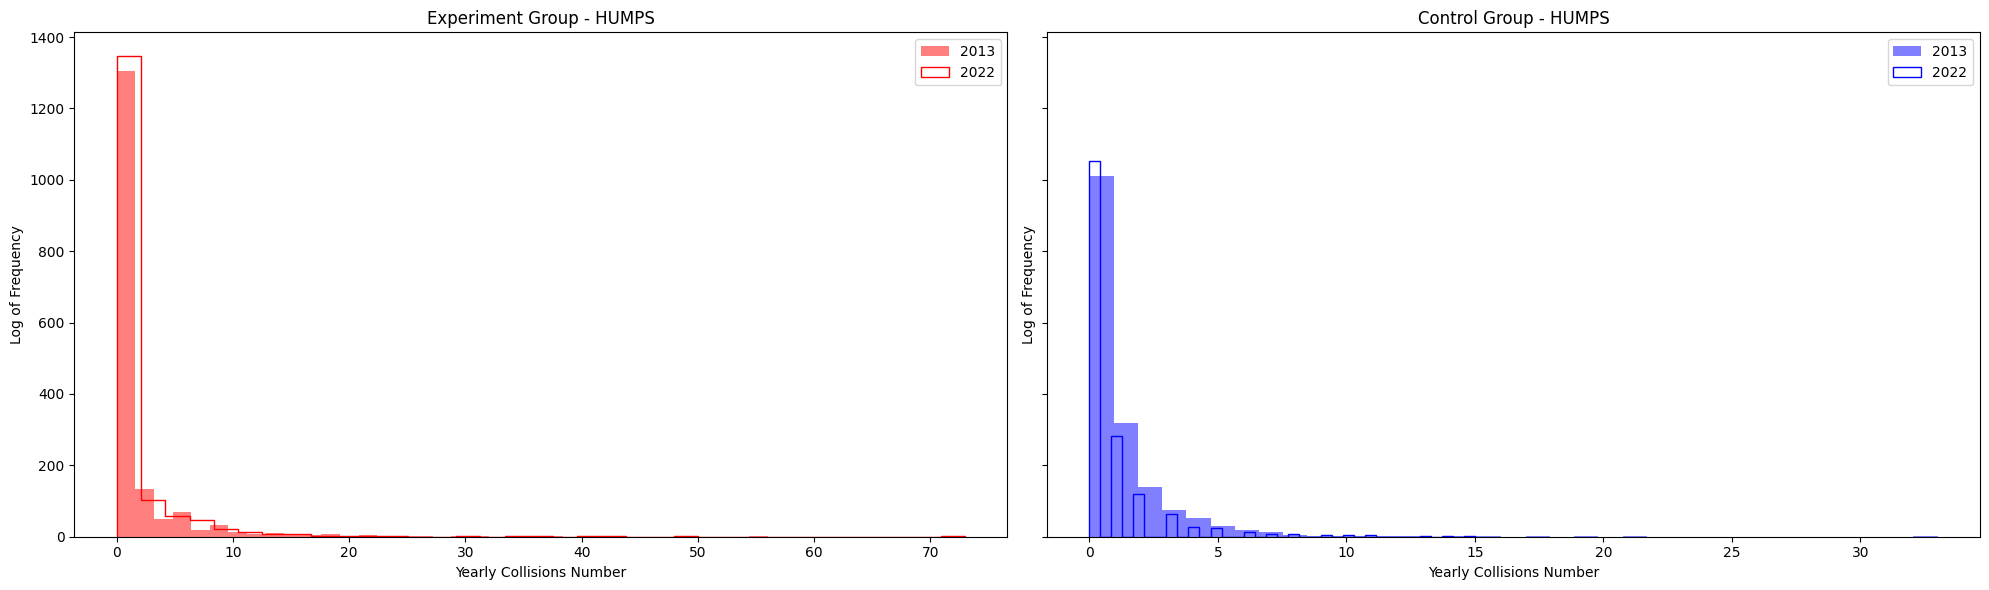

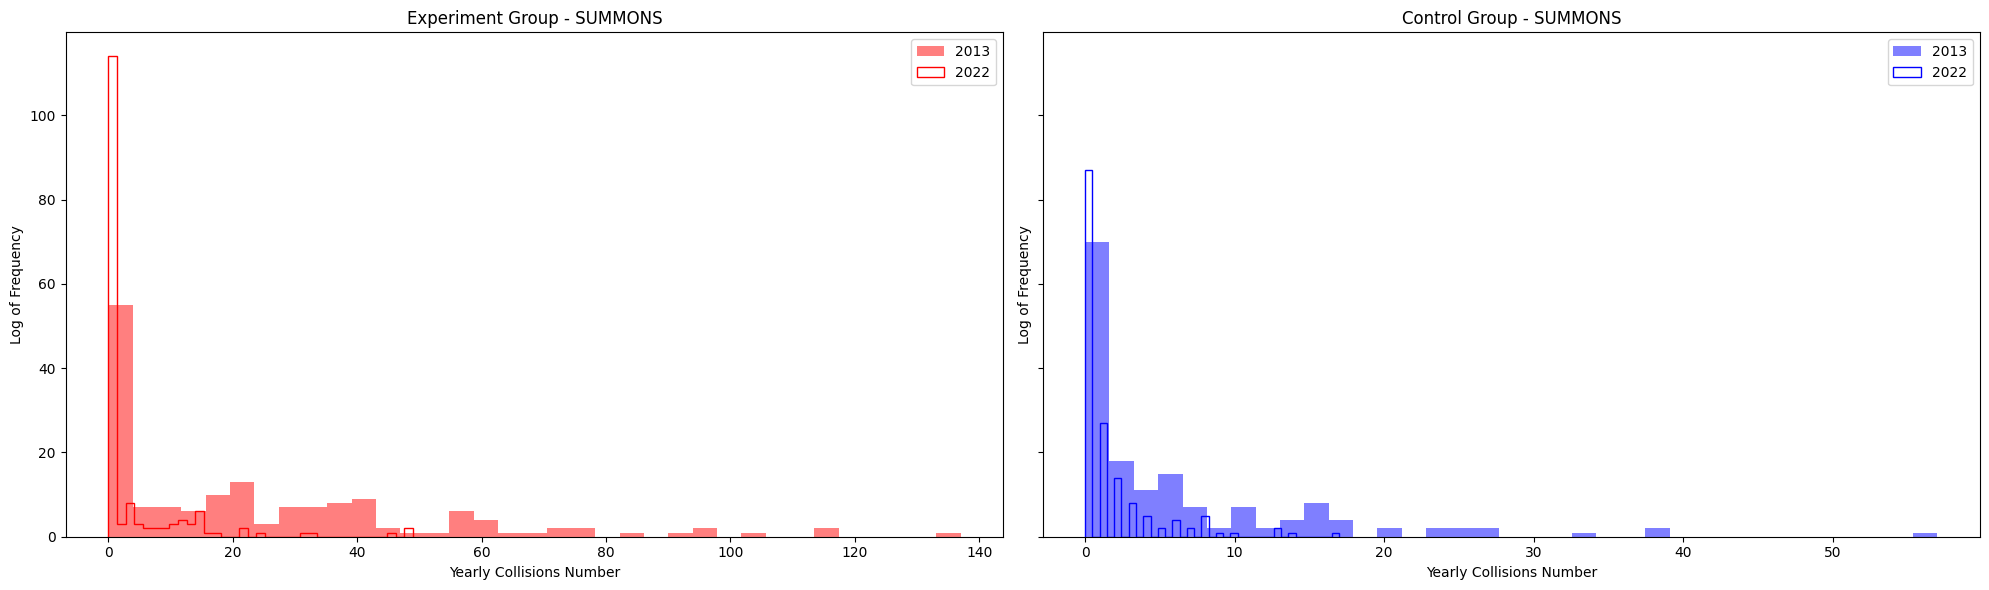

In [ ]:
div = 50
for feature in ["HUMPS", "SUMMONS"]:
  affect_mask = calc_affect_mask(df, feature, div)

  coll_affect_first, coll_no_affect_first, coll_affect_second, coll_no_affect_second = calc_4_df_for_diff_in_diff(df_first, df_second, affect_mask, feature)

  # Create separate histograms for red and blue data
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

  # Plot red data histograms
  ax1.hist(coll_affect_first, bins=35, alpha=0.5, color='red', density=False, label=FIRST_YEAR)
  ax1.hist(coll_no_affect_first, bins=35, color='red', histtype='step', density=False, label=SECOND_YEAR)
  # ax1.set_yscale('log')
  ax1.set_xlabel('Yearly Collisions Number')
  ax1.set_ylabel('Log of Frequency')
  ax1.set_title(f"Experiment Group - {feature}")
  ax1.legend()

  # Plot blue data histograms
  ax2.hist(coll_affect_second, bins=35, alpha=0.5, color='blue', density=False, label=FIRST_YEAR)
  ax2.hist(coll_no_affect_second, bins=35, color='blue', histtype='step', density=False, label=SECOND_YEAR)
  # ax2.set_yscale('log')
  ax2.set_xlabel('Yearly Collisions Number')
  ax2.set_ylabel('Log of Frequency')
  ax2.set_title(f"Control Group - {feature}")
  ax2.legend()

  # Adjust layout for better spacing
  plt.tight_layout()

  # Save the histograms to images
  fig.savefig(f'histogram_red_blue_{feature}.png', format='png')
  plt.show()

# PCA

In [ ]:
div = 1
feat = "HUMPS"
feature_to_test = (((df_second_jan[feat].reset_index(drop=True)-df_first_jan[feat].reset_index(drop=True)))//div)>0
df_filtered_first_agg = df_first.groupby(["ST_INDEX"]).agg({"COLLISIONS":"sum"})
df_filtered_second_agg = df_second.groupby(["ST_INDEX"]).agg({"COLLISIONS":"sum"})

In [ ]:
df_for_knn = (df_second_jan.drop(columns=[feat,"lat", "long"]).iloc[:,5:-1]).reset_index(drop=True)
exp_group_features = df_for_knn[feature_to_test.astype(bool)]
cont_group_features = df_for_knn[~feature_to_test.astype(bool)]
n_neighbors = 1
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(cont_group_features)
distances, indices = knn.kneighbors(exp_group_features)

In [ ]:
(df_second_jan.drop(columns=[feat,"lat", "long"]).iloc[:,5:-1])

,Residential,Education,Cultural,Recreational,Social Services,Transportation,Commercial,Government,Religious Institution,Health Services,...,Bridge,Tunnel,Boardwalk,PathTrail,StepStreet,Driveway,Ramp,Alley,U-Turn,FerryRoute
120,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16228860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
16228994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
16229128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
16229262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
scaler = StandardScaler()
cont_group_features_scaled = scaler.fit_transform(cont_group_features)
exp_group_features_scaled = scaler.transform(exp_group_features)
n_neighbors = 1
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(cont_group_features_scaled)
distances, indices = knn.kneighbors(exp_group_features_scaled)

In [ ]:
color_knn = feature_to_test.astype(bool)
color_knn[cont_group_features.index[indices.flatten()]] = 2
mapping = {0: "nither", 1: "experiment", 2: "control"}
color_knn = color_knn.astype(int).replace(mapping)

color_random = feature_to_test.astype(bool)
n_ones = np.sum(color_random)
zero_indices = np.where(~color_random)[0]
np.random.shuffle(zero_indices)
color_random[zero_indices[:n_ones]] = 2
color_random = color_random.astype(int).replace(mapping)

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_for_knn.T)
x_comp_all = pca.components_[0]
y_comp_all = pca.components_[1]


In [ ]:
fig = px.scatter(x=x_comp_all[color_knn!="nither"], y=y_comp_all[color_knn!="nither"],
                 color =color_knn[color_knn!="nither"], title=f"PCA of All Features Except {feat}",
                 labels={"color":f"{feat} changed"})
fig.show()

In [ ]:
fig = px.scatter(x=x_comp_all[color_random!="nither"], y=y_comp_all[color_random!="nither"],
                 color =color_random[color_random!="nither"], title=f"PCA of All Features Except {feat}",
                 labels={"color":f"{feat} changed"})
fig.show()